import and pip necessary libraries

In [1]:
import pandas as pd 
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

! pip install scikit-surprise
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import SVD, SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
filtered_data = pd.read_csv("filtered_data.csv")
filtered_data.head() 

,userId,productId,rating,timestamp
0,AO94DHGC771SJ,0528881469,5.0,1370131200
1,AMO214LNFCEI4,0528881469,1.0,1290643200
2,A3N7T0DY83Y4IG,0528881469,3.0,1283990400
3,A1H8PY3QHMQQA0,0528881469,2.0,1290556800
4,A24EV6RXELQZ63,0528881469,1.0,1317254400


In [3]:
# Display dataset information and basic statistics
print(filtered_data.info())
print(filtered_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991560 entries, 0 to 1991559
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 60.8+ MB
None
             rating     timestamp
count  1.991560e+06  1.991560e+06
mean   4.201605e+00  1.339592e+09
std    1.205818e+00  6.520485e+07
min    1.000000e+00  9.292320e+08
25%    4.000000e+00  1.316909e+09
50%    5.000000e+00  1.360714e+09
75%    5.000000e+00  1.385078e+09
max    5.000000e+00  1.406074e+09


Data Preprocess

In [4]:
sample_fraction = 0.1
sample_data = filtered_data.sample(frac=sample_fraction)

In [5]:
sample_data

,userId,productId,rating,timestamp
1340798,AWV5SZ880NKXR,B005HMKKH4,5.0,1369440000
1164781,ACE8UPXHT6N8I,B004NBZ98K,5.0,1378339200
154136,AG8SR4D0V4EQW,B00068DIB4,2.0,1213142400
162486,A1B3DQ05GJDLLY,B0007IP4XI,5.0,1106524800
1205934,A3F7USIDJBR8WU,B004THA2OE,5.0,1329177600
...,...,...,...,...
937095,A27BX2HYC3BBY4,B003M0NURK,3.0,1394323200
1177300,AGUGSDBTRKOEY,B004PSEJHS,5.0,1362787200
1407400,A1UJ7DG7BEU9OV,B005Z5HT2M,4.0,1369699200
565795,A1UO0OMCFXQ1TG,B001ID49BO,5.0,1291766400


Item-Item Collaborative Filtering model

Transfer data into Surprise format, and split train and test data

In [7]:
reader = Reader(rating_scale=(1, 5))

surprise_data = Dataset.load_from_df(filtered_data[['userId', 'productId', 'rating']], reader)
surprise_subsetdata = Dataset.load_from_df(sample_data[['userId', 'productId', 'rating']], reader)

SVD and SVD++

In [8]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_epochs': [5, 10, 15, 20],
    'lr_all': [0.002, 0.005, 0.008],
    'reg_all': [0.2, 0.4, 0.6]
}

# Perform GridSearchCV for SVD
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_svd.fit(surprise_subsetdata)

# Print the best parameters for SVD
print("Best parameters for SVD: ", grid_search_svd.best_params['rmse'])

Best parameters for SVD:  {'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.6}


In [9]:
# Perform GridSearchCV for SVD++
grid_search_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_svdpp.fit(surprise_subsetdata)

# Print the best parameters for SVD++
print("Best parameters for SVD++: ", grid_search_svdpp.best_params['rmse'])

Best parameters for SVD++:  {'n_epochs': 15, 'lr_all': 0.008, 'reg_all': 0.4}


In [10]:
# Cross-validate the best SVD model
best_svd = SVD(**grid_search_svd.best_params['rmse'])
cv_results_svd = cross_validate(best_svd, surprise_data, measures=['rmse', 'mae'], cv=5, verbose=False)

# Cross-validate the best SVD++ model
best_svdpp = SVDpp(**grid_search_svdpp.best_params['rmse'])
cv_results_svdpp = cross_validate(best_svdpp, surprise_data, measures=['rmse', 'mae'], cv=5, verbose=False)

mean_rmse_svd = cv_results_svd['test_rmse'].mean()
mean_mae_svd = cv_results_svd['test_mae'].mean()

print(f"Mean RMSE of svd: {mean_rmse_svd:.4f}")
print(f"Mean MAE of svd: {mean_mae_svd:.4f}")

mean_rmse_svdpp = cv_results_svdpp['test_rmse'].mean()
mean_mae_svdpp = cv_results_svdpp['test_mae'].mean()

print(f"Mean RMSE of svdpp: {mean_rmse_svdpp:.4f}")
print(f"Mean MAE of svdpp: {mean_mae_svdpp:.4f}")

Mean RMSE of svd: 1.1617
Mean MAE of svd: 0.8928
Mean RMSE of svdpp: 1.1615
Mean MAE of svdpp: 0.8912


In [11]:
'''
best_svd.fit(surprise_data.build_full_trainset())
best_svdpp.fit(surprise_data.build_full_trainset())

# Save the best SVD model
with open("best_svd_model.pkl", "wb") as f:
    pickle.dump(best_svd, f)

# Save the best SVD++ model
with open("best_svdpp_model.pkl", "wb") as f:
    pickle.dump(best_svdpp, f)
'''

Basic KNN and KNN Baseline

In [12]:
# Parameter grid for KNNBasic and KNNWithMeans
param_grid = {
    'k': [10, 30, 50]
}

# Perform GridSearchCV for KNNBasic
grid_search_knnbasic = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_knnbasic.fit(surprise_subsetdata)

# Print the best parameters for KNNBasic
print("Best parameters for KNNBasic: ", grid_search_knnbasic.best_params['rmse'])

Best parameters for KNNBasic:  {'k': 10}


In [13]:
# Perform GridSearchCV for KNNBaseline
grid_search_knnbaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_knnbaseline.fit(surprise_subsetdata)

# Print the best parameters for KNNBaseline
print("Best parameters for KNNBaseline: ", grid_search_knnbaseline.best_params['rmse'])

Best parameters for KNNBaseline:  {'k': 10}


Basic KNN

In [14]:
# Train the basic KNN model
basic_knn = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': False})

# Run 5-fold cross-validation
cv_results_knnbasic = cross_validate(basic_knn, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


KNN Baseline

In [15]:
# Train the k-NN baseline model using the best parameters
base_knn = KNNBaseline(k=10, sim_options={'name': 'msd', 'user_based': False})

# Run 5-fold cross-validation
cv_results_knnbaseline = cross_validate(base_knn, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [17]:
mean_rmse_knnbasic = cv_results_knnbasic['test_rmse'].mean()
mean_mae_knnbasic = cv_results_knnbasic['test_mae'].mean()

print(f"Mean RMSE of knnbasic: {mean_rmse_knnbasic:.4f}")
print(f"Mean MAE of knnbasic: {mean_mae_knnbasic:.4f}")

mean_rmse_knnbaseline = cv_results_knnbaseline['test_rmse'].mean()
mean_mae_knnbaseline = cv_results_knnbaseline['test_mae'].mean()

print(f"Mean RMSE of knnbaseline: {mean_rmse_knnbaseline:.4f}")
print(f"Mean MAE of knnbaseline: {mean_mae_knnbaseline:.4f}")

Mean RMSE of knnbasic: 1.2144
Mean MAE of knnbasic: 0.9439
Mean RMSE of knnbaseline: 1.1715
Mean MAE of knnbaseline: 0.8929


In [20]:
'''
basic_knn.fit(surprise_data.build_full_trainset())
base_knn.fit(surprise_data.build_full_trainset())

# Save the best SVD model
with open("basic_knn.pkl", "wb") as f:
    pickle.dump(basic_knn, f)

# Save the best SVD++ model
with open("base_knn.pkl", "wb") as f:
    pickle.dump(base_knn, f)
'''

'\nbasic_knn.fit(surprise_data.build_full_trainset())\nbase_knn.fit(surprise_data.build_full_trainset())\n\n# Save the best SVD model\nwith open("basic_knn.pkl", "wb") as f:\n    pickle.dump(basic_knn, f)\n\n# Save the best SVD++ model\nwith open("base_knn.pkl", "wb") as f:\n    pickle.dump(base_knn, f)\n'

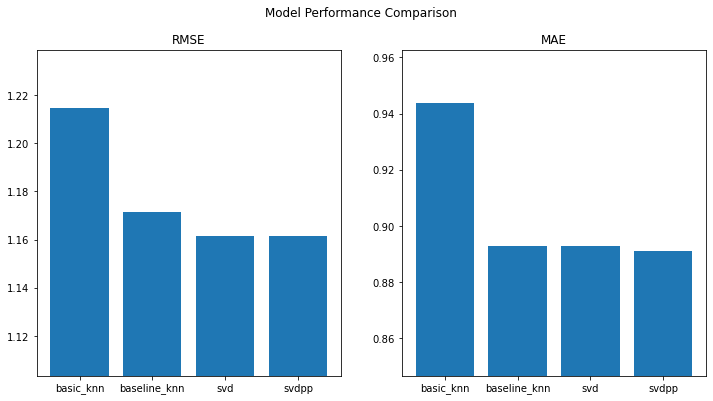

In [18]:
rmse_means = []
mae_means = []

rmse_means.append(mean_rmse_knnbasic)
rmse_means.append(mean_rmse_knnbaseline)
rmse_means.append(mean_rmse_svd)
rmse_means.append(mean_rmse_svdpp)

mae_means.append(mean_mae_knnbasic)
mae_means.append(mean_mae_knnbaseline)
mae_means.append(mean_mae_svd)
mae_means.append(mean_mae_svdpp)

x_labels = ['basic_knn', 'baseline_knn', 'svd', 'svdpp']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Model Performance Comparison')

ax1.bar(x_labels, rmse_means)
ax1.set_title('RMSE')
ax1.set_ylim([min(rmse_means) * 0.95, max(rmse_means) * 1.02])

ax2.bar(x_labels, mae_means)
ax2.set_title('MAE')
ax2.set_ylim([min(mae_means) * 0.95, max(mae_means) * 1.02])

plt.show()